## 주식 예측

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
%matplotlib inline
# 한글폰트 사용
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)
import warnings
warnings.filterwarnings("ignore")

In [2]:
from fbprophet import Prophet
from datetime import datetime

## pandas_datareader 모듈

In [13]:
import pandas_datareader.data as web

In [15]:
# Datetime 객체를 만들 때 1월 1일을 01,01로 입력하지 않고 1,1로 입력한다
start = datetime(2019,1,1)
end = datetime(2020,12,7)

In [19]:
GS = web.DataReader('078930.KS', 'yahoo', start, end)
GS.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,51200.0,48200.0,51100.0,48500.0,271228.0,48500.0
2019-01-03,49150.0,47900.0,49150.0,48350.0,178992.0,48350.0
2019-01-04,49450.0,47950.0,47950.0,49250.0,166264.0,49250.0
2019-01-07,50700.0,49600.0,49650.0,50300.0,118533.0,50300.0
2019-01-08,50600.0,49650.0,50500.0,49900.0,112218.0,49900.0


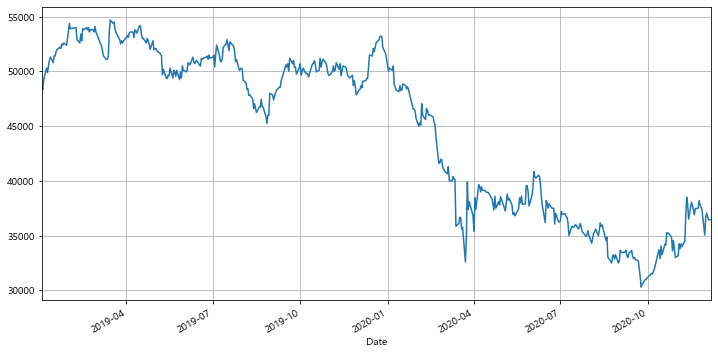

In [23]:
# 종가 그래프
GS.Close.plot(figsize=(12,6), grid=True);

- 참값과 예측값을 비교하기 위해 일부 데이터를 삭제한 후 forecast

In [24]:
GS_truncated = GS[:'2020-10-31']
GS_truncated.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,51200.0,48200.0,51100.0,48500.0,271228.0,48500.0
2019-01-03,49150.0,47900.0,49150.0,48350.0,178992.0,48350.0
2019-01-04,49450.0,47950.0,47950.0,49250.0,166264.0,49250.0
2019-01-07,50700.0,49600.0,49650.0,50300.0,118533.0,50300.0
2019-01-08,50600.0,49650.0,50500.0,49900.0,112218.0,49900.0


In [29]:
df = pd.DataFrame({'ds':GS_truncated.index,
                    'y':GS_truncated.Close})
df.reset_index(inplace=True)
del df['Date']
df.head(3)

,ds,y
0,2019-01-02,48500.0
1,2019-01-03,48350.0
2,2019-01-04,49250.0


In [32]:
# 모델 학습
model = Prophet(yearly_seasonality=True,daily_seasonality=True)
model.fit(df)

In [35]:
# 예측 날짜
future = model.make_future_dataframe(periods=35)
future.tail(3)

,ds
483,2020-12-02
484,2020-12-03
485,2020-12-04


In [37]:
# 예측하려는 날짜 예측값, lower bound, high bound
forecast = model.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
481,2020-11-30,30807.341030,29529.636377,32158.806882
482,2020-12-01,31013.371744,29652.431766,32348.570872
483,2020-12-02,31140.441763,29869.649366,32521.110784
484,2020-12-03,31258.123164,29910.307267,32575.642457
485,2020-12-04,31307.757177,29884.881824,32684.591897


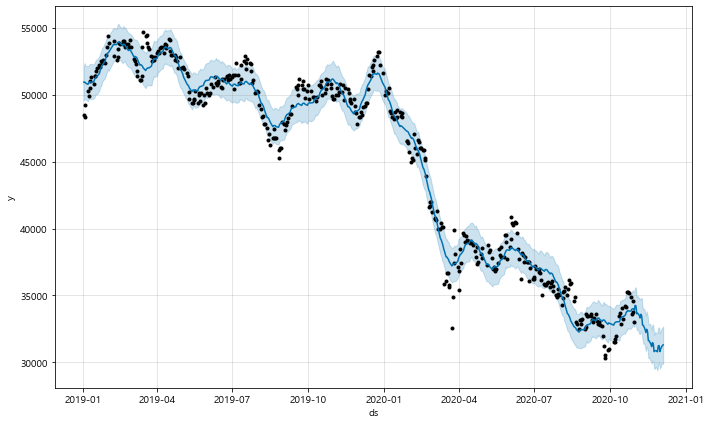

In [39]:
# 예측 데이터
model.plot(forecast);

- 실제 데이터와 동시에 비교

In [49]:
# 실제 데이터
GS.head(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,51200.0,48200.0,51100.0,48500.0,271228.0,48500.0
2019-01-03,49150.0,47900.0,49150.0,48350.0,178992.0,48350.0
2019-01-04,49450.0,47950.0,47950.0,49250.0,166264.0,49250.0


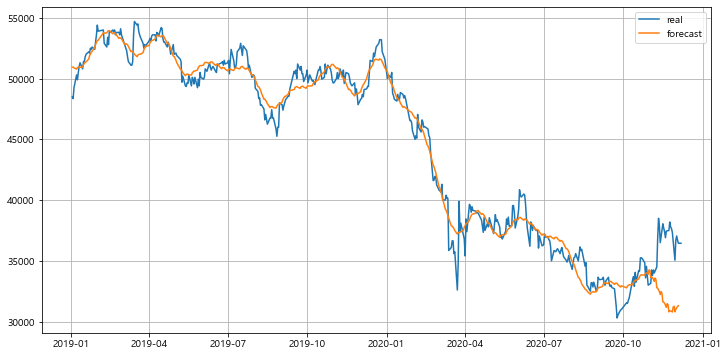

In [50]:
plt.figure(figsize=(12,6))
plt.plot(GS.index, GS.Close, label='real')
plt.plot(forecast.ds, forecast.yhat, label='forecast')
plt.grid()
plt.legend()
plt.show()

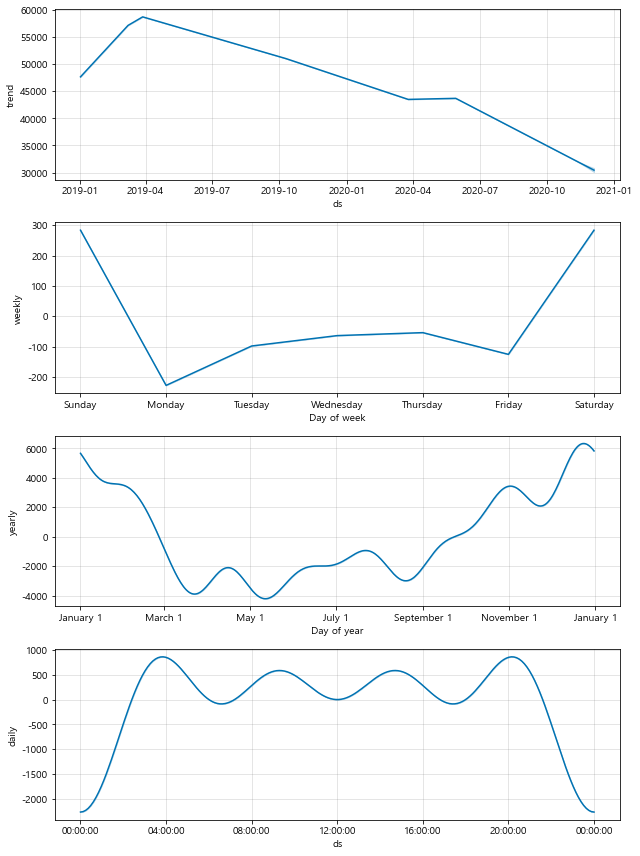

In [40]:
model.plot_components(forecast);

## Growth Model과 Holiday Forecast

In [55]:
df = pd.read_csv('./source/example_wp_R.csv', thousands=',')
df.head(3)

,ds,y
0,2008-01-30,394
1,2008-01-16,424
2,2008-01-17,408


In [56]:
# y값 로그변환
df.y = np.log(df.y)
# 변수 cap = 8.5 추가
df['cap'] = 8.5

In [57]:
model = Prophet(growth='logistic',daily_seasonality=True)
model.fit(df)

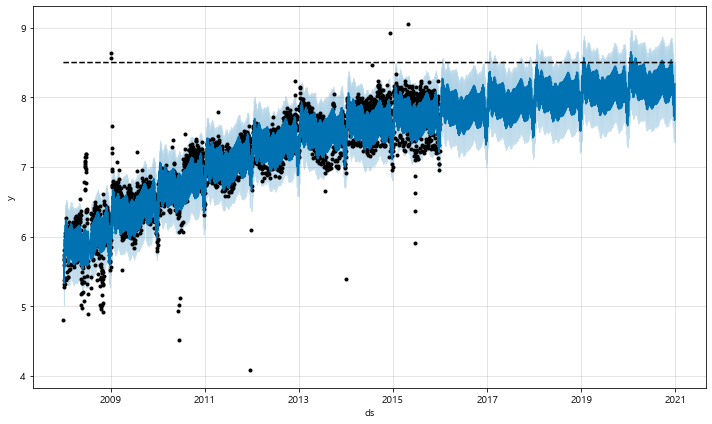

In [59]:
future = model.make_future_dataframe(periods=1826)
future['cap'] = 8.5
forecast = model.predict(future)
model.plot(forecast);

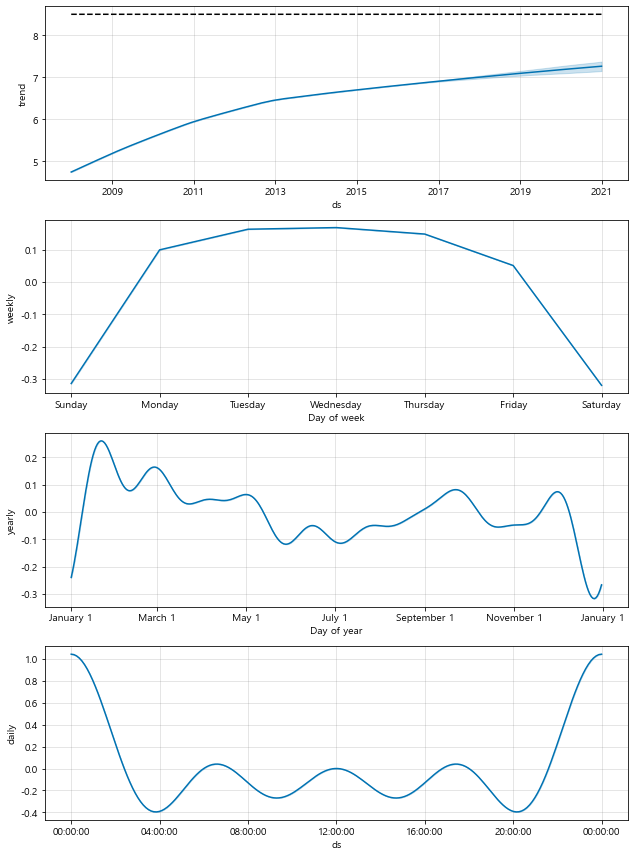

In [60]:
model.plot_components(forecast);

## Holiday
- 만약 특정 기간에 값이 비정상적으로 증가 또는, 감소했다면, holiday로 정의하여 모델에 반영할 수 있다.

In [67]:
df = pd.read_csv('./source/example_wp_peyton_manning.csv', sep=',')
df['y'] = np.log(df['y'])
df.head(3)

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677


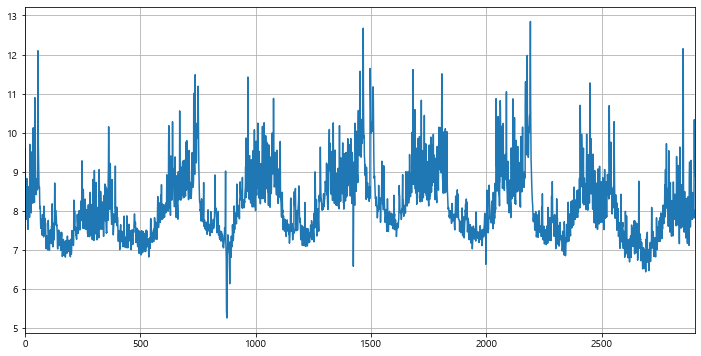

In [69]:
df.y.plot(figsize = (12,6), grid = True)
plt.show()

- holiday df와 superbowl df(휴일이 아닐 때)

In [70]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

In [71]:
playoffs.head(2)

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1


In [72]:
superbowls.head(2)

,holiday,ds,lower_window,upper_window
0,superbowl,2010-02-07,0,1
1,superbowl,2014-02-02,0,1


In [73]:
holidays = pd.concat([playoffs,superbowls])

In [81]:
# 향후 60일에 대해 예측
future = model.make_future_dataframe(periods=60)

In [82]:
model = Prophet(holidays=holidays, daily_seasonality=True)
forecast = model.fit(df).predict(future)

In [83]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.224116,1.203719
2191,2014-02-03,1.902824,1.458890
2532,2015-01-11,1.224116,0.000000
2533,2015-01-12,1.902824,0.000000
2901,2016-01-17,1.224116,0.000000
2902,2016-01-18,1.902824,0.000000
2908,2016-01-24,1.224116,0.000000
2909,2016-01-25,1.902824,0.000000
2922,2016-02-07,1.224116,1.203719
2923,2016-02-08,1.902824,1.458890


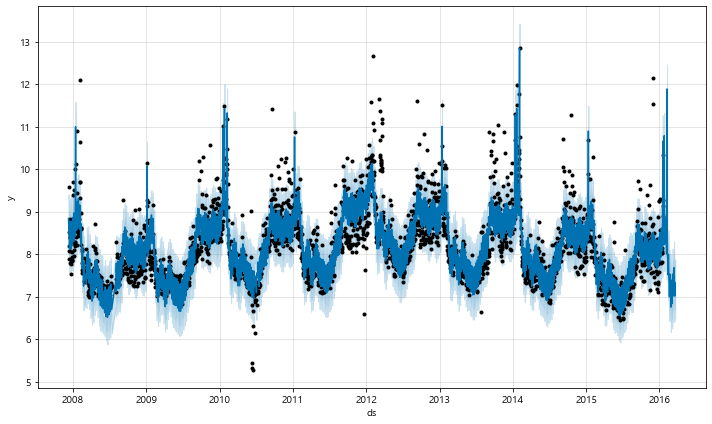

In [84]:
model.plot(forecast);

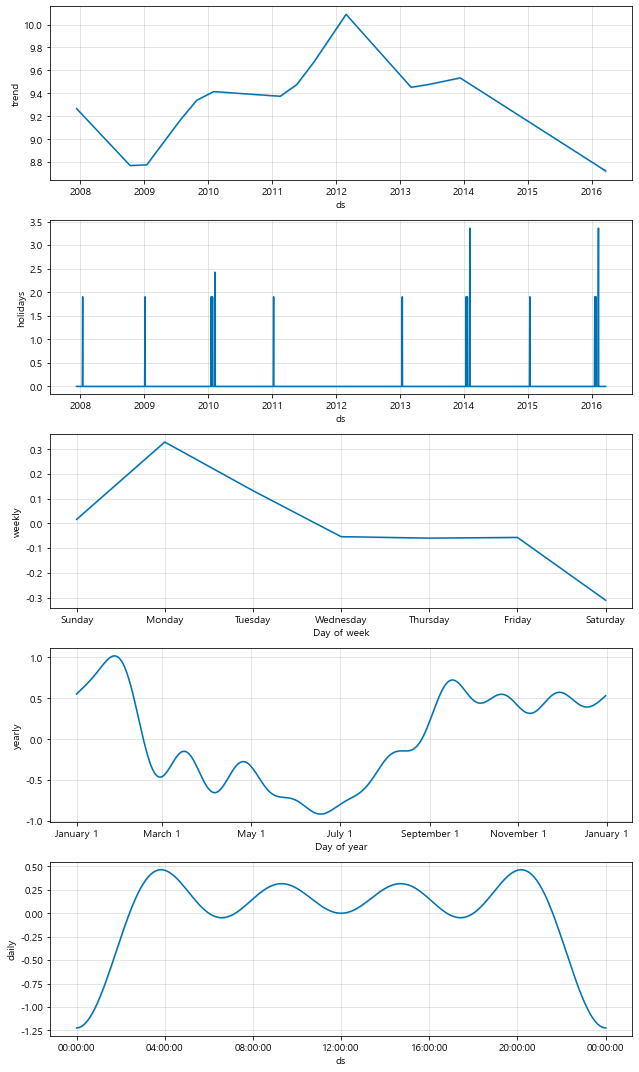

In [85]:
model.plot_components(forecast);